<a id='content'></a>
# Содержание
- [Загрузка библиотек](#include_libs)
- [Вспомогательные функции](#supporting_functions)
- [Открытие CSV файла с базой данных](#df_open)
- [Задание 2.1](#task_2_1)
- [Задание 2.2](#task_2_2)
- [Черновик](#drft)


[Вернуться в начало](#content)
<a id='include_libs'></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import typer
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
pio.renderers.default='notebook'
import mpl_toolkits.mplot3d
import optuna
import itertools
from scipy.cluster.hierarchy import dendrogram
from matplotlib.gridspec import GridSpec
from collections import defaultdict

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV 
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.metrics import (
    auc, 
    roc_curve, 
    roc_auc_score, 
    recall_score,
    brier_score_loss,
    precision_recall_curve, 
    f1_score, 
    fbeta_score, 
    log_loss,
    confusion_matrix, 
    precision_score,  
    accuracy_score, 
    mean_squared_error,
    r2_score, 
    median_absolute_error, 
    classification_report 
)
from sklearn.metrics import silhouette_score, rand_score
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_blobs, load_iris
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn import datasets, decomposition
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

[Вернуться в начало](#content)
<a id='supporting_functions'></a>

In [2]:
def plot_probability_curves(do_calibration=False, method_option='isotonic'):
  fig = plt.figure(figsize=(10, 10))
  gs = GridSpec(5, 2)
  colors = plt.cm.get_cmap("Dark2")

  ax_calibration_curve = fig.add_subplot(gs[:2, :2])
  calibration_displays = {}
  for i, clf in enumerate(clf_list):
    name = clf.__class__.__name__
    if do_calibration:
      clf = CalibratedClassifierCV(clf, cv="prefit", method=method_option) #method='isotonic'
      clf.fit(X_valid, y_valid)
    else:
      clf.fit(X_train, y_train)

    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display
    

  ax_calibration_curve.grid()
  ax_calibration_curve.set_title("Calibration plots")
    
  grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1)]
  for i, clf in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    name = clf.__class__.__name__
    plt.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    plt.title(name)
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Count")

  plt.tight_layout()
  plt.show()
  scores = defaultdict(list)
  for i, clf in enumerate(clf_list):
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        y_pred = clf.predict(X_test)
        scores["Classifier"].append(name)
    
        for metric in [brier_score_loss, log_loss, roc_auc_score]:
            score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
            scores[score_name].append(metric(y_test, y_prob[:, 1]))
    
        for metric in [precision_score, recall_score, f1_score]:
            score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
            scores[score_name].append(metric(y_test, y_pred))
    
        score_df = pd.DataFrame(scores).set_index("Classifier")
        score_df.round(decimals=3)
  print(score_df.head())

In [3]:
def plot_probability_curves_2(clf_in):
    clf_in_isotonic = CalibratedClassifierCV(clf_in, cv=2, method="isotonic")
    clf_in_sigmoid = CalibratedClassifierCV(clf_in, cv=2, method="sigmoid")
    
    clf_list = [
        (clf_in, clf_in.__class__.__name__),
        (clf_in_isotonic, clf_in.__class__.__name__ + "_Isotonic"),
        (clf_in_sigmoid, clf_in.__class__.__name__ + "_Sigmoid"),
    ]

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = plt.get_cmap("Dark2")
    
    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    calibration_displays = {}
    for i, (clf, name) in enumerate(clf_list):
        clf.fit(X_train, y_train)
        display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
        )
        calibration_displays[name] = display
    
    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")
    
    # Add histogram
    grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
    for i, (_, name) in enumerate(clf_list):
        row, col = grid_positions[i]
        ax = fig.add_subplot(gs[row, col])
    
        ax.hist(
            calibration_displays[name].y_prob,
            range=(0, 1),
            bins=10,
            label=name,
            color=colors(i),
        )
        ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")
    
    plt.tight_layout()
    plt.show()

In [4]:
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest", "KNN", "DecisionTreeClassifier"])
    
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = SVC(C=svc_c, gamma="auto")
        
    elif classifier_name == "KNN":
        n_neigh = trial.suggest_int("n_neigh", 2, 10, log=True)
        classifier_obj = KNeighborsClassifier(n_neighbors=n_neigh)

    elif classifier_name == "DecisionTreeClassifier":
        max_depth = trial.suggest_int("max_depth", 2, 50, log=True)
        classifier_obj = DecisionTreeClassifier(max_depth=max_depth)
        
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)
        
    score = cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def qwerty(model, name):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, model.predict(X_test), target_names=['Bad', 'Good'])
    print(name)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')
    print(report)

[Вернуться в начало](#content)
<a id='df_open'></a>

In [7]:
path = Path.cwd()
files = []
for ext in ['*.csv']:
    files += [p for p in Path(path).glob(ext) if p.is_file()]
    
data = pd.read_csv(files[0], delimiter=',')
df = pd.DataFrame(data)

df = df.drop(columns='A_id')

num_cols = df.select_dtypes(exclude='object')

df.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,good
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,good
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,bad
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,good
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,good


<a id='task_2_1'></a>
[Вернуться в начало](#content)
# Задание 2.1
Построить более сложную модель с подбором гиперпараметров

В рамках данного пункта необходимо использовать более сложную модель для решения задачи,  оптимизировать гиперпараметры и оценить ее качество.

Критерии оценки:
- Выбрана более сложная ML-модель - **1 балл** <font color='green'>(status)</font>.
- Произведен подбор гиперпараметров с использованием кросс-валидации - **4 балла** <font color='green'>(status)</font>.
- Выбранная модель обучена с лучшими подобранными значениями гиперпараметров - **4 балла** <font color='green'>(status)</font>.
- Произведено измерение качества на отложенной выборке с использованием ранее выбранной метрики - **1 балл** <font color='green'>(status)</font>.
- Предполагается, что студенты продвинутого трека среди прочего продемонстрируют использование библиотеки optuna для подбора гиперпараметров <font color='green'>(status)</font>.

In [8]:
X = df.drop('Quality', axis=1) # dataset
y = df['Quality'].replace(to_replace=['good', 'bad'], value=[1, 0]) # target
# X = df[['Size', 'Sweetness']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [9]:
# svc_c_list = np.linspace( 1, 5, 100)
# result: list = []
# for svc_c in svc_c_list:
#     classifier_obj = SVC(C=svc_c, gamma="auto")
#     score = cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=3)
#     accuracy = score.mean()
#     result.append(accuracy)
# result = np.array(result)

# plt.plot(svc_c_list, result)
# plt.xlabel('Hyperparameter SVC-C')
# plt.ylabel('Accuracy')
# plt.ylim(0.9, 0.92)
# # plt.yscale('log')
# plt.show()

In [10]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2024-02-21 18:46:25,416] A new study created in memory with name: no-name-454324f1-8804-4e5d-b96c-4e786f546ff2
[I 2024-02-21 18:46:27,663] Trial 0 finished with value: 0.8505008560985824 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 10}. Best is trial 0 with value: 0.8505008560985824.
[I 2024-02-21 18:46:29,108] Trial 1 finished with value: 0.6637498954948632 and parameters: {'classifier': 'DecisionTreeClassifier', 'max_depth': 2}. Best is trial 0 with value: 0.8505008560985824.
[I 2024-02-21 18:46:30,519] Trial 2 finished with value: 0.8910010486129778 and parameters: {'classifier': 'KNN', 'n_neigh': 7}. Best is trial 2 with value: 0.8910010486129778.
[I 2024-02-21 18:46:30,578] Trial 3 finished with value: 0.8067530375847335 and parameters: {'classifier': 'DecisionTreeClassifier', 'max_depth': 40}. Best is trial 2 with value: 0.8910010486129778.
[I 2024-02-21 18:46:30,732] Trial 4 finished with value: 0.8614974208319696 and parameters: {'classifier': 'KNN', 'n_nei

In [11]:
print(study.best_trial)

FrozenTrial(number=19, state=1, values=[0.9089991763308144], datetime_start=datetime.datetime(2024, 2, 21, 18, 46, 33, 839896), datetime_complete=datetime.datetime(2024, 2, 21, 18, 46, 34, 376285), params={'classifier': 'SVC', 'svc_c': 0.7176650281076629}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'RandomForest', 'KNN', 'DecisionTreeClassifier')), 'svc_c': FloatDistribution(high=10000000000.0, log=True, low=1e-10, step=None)}, trial_id=19, value=None)


In [12]:
svc_class = SVC(C=3.018527317337294, gamma="auto")
svc_class.fit(X_train, y_train)
y_pred_svc_class = svc_class.predict(X_test)

Confusion matrix, without normalization
[[449  57]
 [ 40 454]]


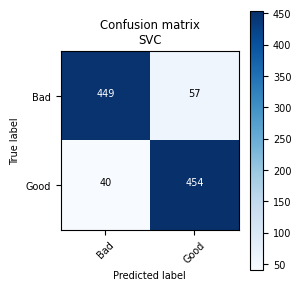

In [13]:
font = {'size' : 7}

plt.rc('font', **font)

plt.figure(figsize=(3, 3))

cnf_matrix = confusion_matrix(y_test, y_pred_svc_class)
plot_confusion_matrix(cnf_matrix, classes=['Bad', 'Good'], title='Confusion matrix\nSVC')

plt.tight_layout()
plt.show()

In [14]:
qwerty(svc_class, '\n---SVC---\n')


---SVC---

Accuracy:  0.903
RMSE: 0.31144823004794875
              precision    recall  f1-score   support

         Bad       0.92      0.89      0.90       506
        Good       0.89      0.92      0.90       494

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



<a id='task_2_2'></a>
[Вернуться в начало](#content)
# Задание 2.2
- Проинтерпретировать полученную модель

В рамках данного пункта необходимо проинтерпретировать модель, полученную в предыдущем пункте.

Критерии оценки:
- Получена интерпретация построенной модели, включая визуализации (коэффициенты/permutation importances/shap и тд) - **5 баллов** <font color='green'>(status)</font>.
- Приведено экспертное мнение о полученной интерпретации (вы, как эксперт в предметной области, можете оценить адекватность признаков и решений, принимаемых моделью, и выразить свое мнение в 1-2 предложении) - **5 баллов** <font color='green'>(status)</font>.

Были обучено несколько моделей с помощью небольшого набора обучающих данных, а затем были построены калибровочные кривые (также известные как диаграммы надежности), при использовании прогнозируемой вероятности набора тестовых данных. Калибровочные кривые создаются путем группирования прогнозируемых вероятностей с последующим построением графика средней прогнозируемой вероятности в каждом интервале в зависимости от наблюдаемой частоты («доля положительных значений»). После этого представлены гистограммы, показывающую распределение прогнозируемых вероятностей или количество выборок в каждом интервале прогнозируемых вероятностей.

В случае некалиброванных данных, на калибровочных кривых лучше всего себя проявляет LogisticRegression (все точки располагаются ближе всего к идеальному случаю, чем для других моделей).

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=2023, test_size=0.25)

In [16]:
clf_list: list = []

clf_list.append(RandomForestClassifier(random_state=2023))
clf_list.append(LogisticRegression())
# clf_list.append(SVC(C=3.018527317337294, gamma="auto"))
clf_list.append(KNeighborsClassifier(n_neighbors=6))
clf_list.append(DecisionTreeClassifier(max_depth=5))
clf_list.append(RandomForestClassifier(max_depth=10, n_estimators=10))
clf_list.append(GaussianNB())


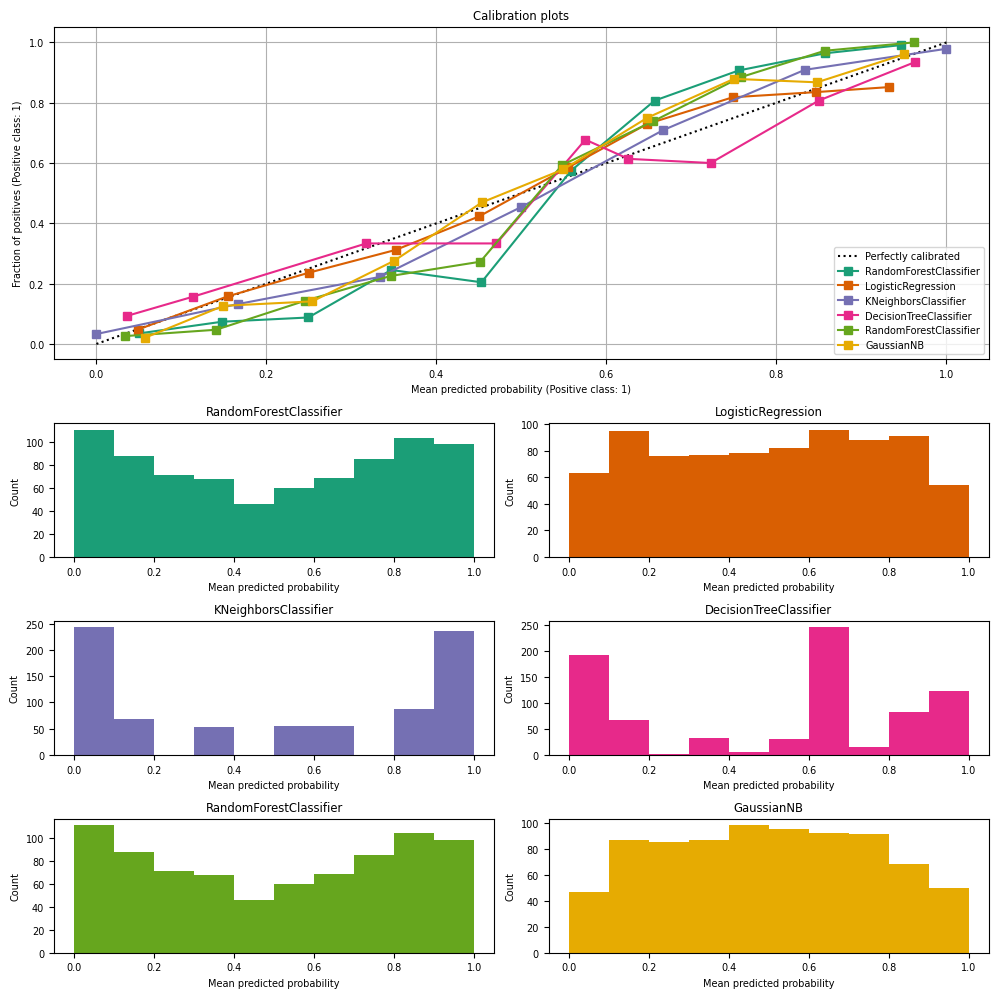

                        Brier  loss  Log loss  Roc auc   Precision    Recall   \
Classifier                                                                      
RandomForestClassifier     0.091681  0.315561  0.951033    0.899263  0.903704   
LogisticRegression         0.170465  0.517283  0.824691    0.759124  0.770370   
KNeighborsClassifier       0.079826  0.782621  0.952658    0.923684  0.866667   
DecisionTreeClassifier     0.155606  0.598486  0.844229    0.728916  0.896296   
RandomForestClassifier     0.108543  0.365143  0.932855    0.834499  0.883951   

                             F1   
Classifier                        
RandomForestClassifier  0.901478  
LogisticRegression      0.764706  
KNeighborsClassifier    0.894268  
DecisionTreeClassifier  0.803987  
RandomForestClassifier  0.858513  


In [17]:
plot_probability_curves(do_calibration=False, method_option='isotonic')

Можно произвести операцию калибровки для улучшения предсказательной способности модели.

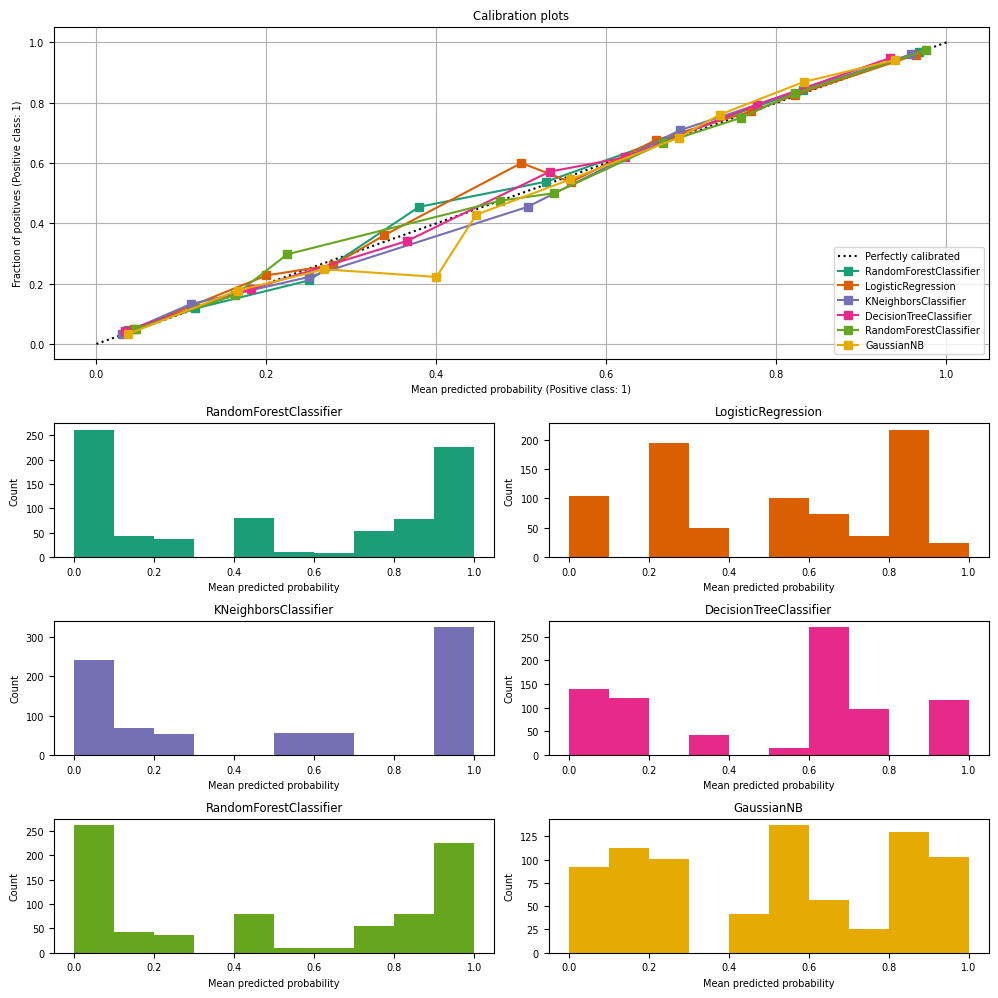

                        Brier  loss  Log loss  Roc auc   Precision    Recall   \
Classifier                                                                      
RandomForestClassifier     0.091681  0.315561  0.951033    0.899263  0.903704   
LogisticRegression         0.170465  0.517283  0.824691    0.759124  0.770370   
KNeighborsClassifier       0.079826  0.782621  0.952658    0.923684  0.866667   
DecisionTreeClassifier     0.155606  0.598486  0.844229    0.728916  0.896296   
RandomForestClassifier     0.110344  0.400825  0.926842    0.860294  0.866667   

                             F1   
Classifier                        
RandomForestClassifier  0.901478  
LogisticRegression      0.764706  
KNeighborsClassifier    0.894268  
DecisionTreeClassifier  0.803987  
RandomForestClassifier  0.863469  


In [18]:
plot_probability_curves(do_calibration=True, method_option='isotonic')

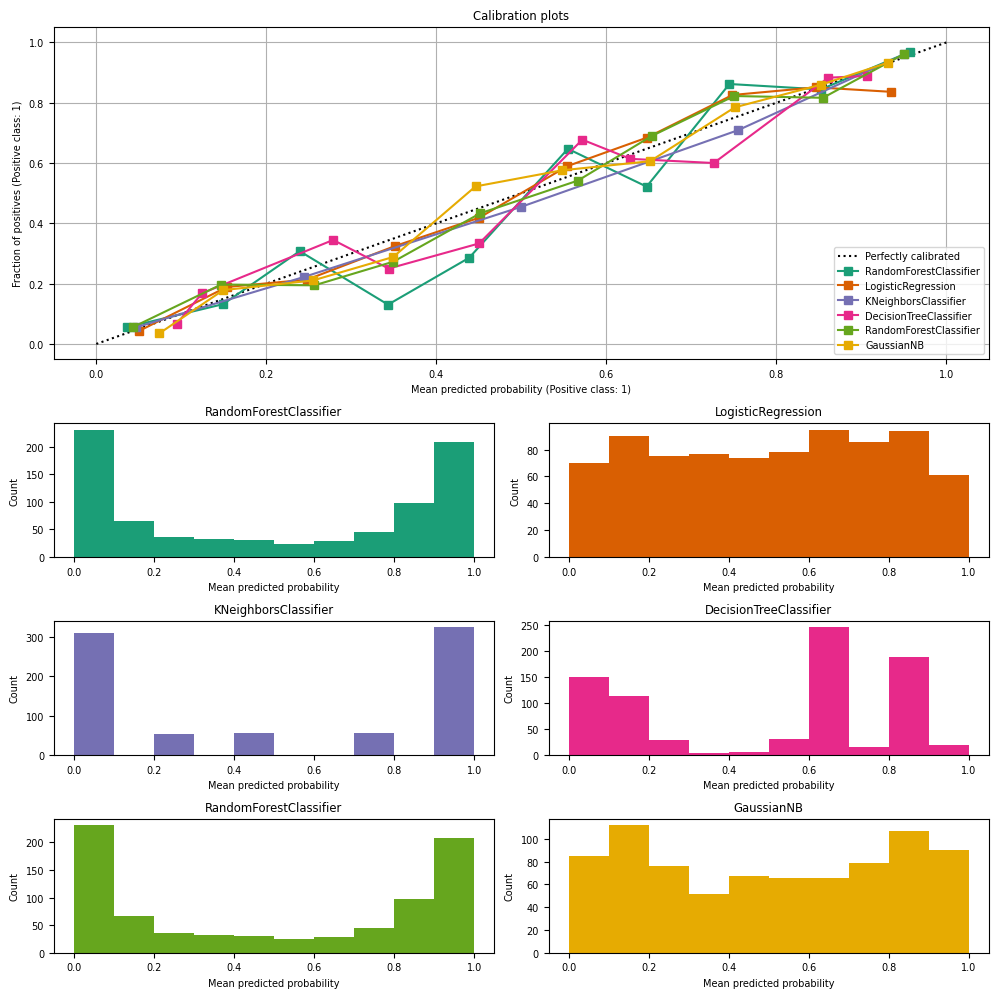

                        Brier  loss  Log loss  Roc auc   Precision    Recall   \
Classifier                                                                      
RandomForestClassifier     0.091681  0.315561  0.951033    0.899263  0.903704   
LogisticRegression         0.170465  0.517283  0.824691    0.759124  0.770370   
KNeighborsClassifier       0.079826  0.782621  0.952658    0.923684  0.866667   
DecisionTreeClassifier     0.155606  0.598486  0.844229    0.728916  0.896296   
RandomForestClassifier     0.110307  0.365119  0.928692    0.855107  0.888889   

                             F1   
Classifier                        
RandomForestClassifier  0.901478  
LogisticRegression      0.764706  
KNeighborsClassifier    0.894268  
DecisionTreeClassifier  0.803987  
RandomForestClassifier  0.871671  


In [19]:
plot_probability_curves(do_calibration=True, method_option='sigmoid')

<a id='draft'></a>
[Вернуться в начало](#content)
# Черновик